In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from glob import glob
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model 
from PIL import Image

Using TensorFlow backend.


## Create Path

 <font size='4'>[Link to Kaggle X-Ray Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)</font>

In [2]:
#Cloud Path
path_to_train = '/home/ubuntu/project/chest_xray/train'
path_to_test = '/home/ubuntu/project/chest_xray/test'
path_to_val = '/home/ubuntu/project/chest_xray/val'

In [2]:
#Mac Path
path_to_train = '/Users/ferhat/Desktop/X_RAY/data/train'
path_to_test = '/Users/ferhat/Desktop/X_RAY/data/test/'
path_to_val = '/Users/ferhat/Desktop/X_RAY/data/val/'

In [4]:
#spot path
path_to_train = '/home/ubuntu/chest_xray/chest_xray/train'
path_to_test = '/home/ubuntu/chest_xray/chest_xray/test'
path_to_val = '/home/ubuntu/chest_xray/chest_xray/val'

In [3]:
os.listdir(path_to_train)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [4]:
os.listdir(path_to_test)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [5]:
os.listdir(path_to_val)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [6]:
train_cat = [x for x in os.listdir(path_to_train) if x[0] is not '.']
test_cat = [x for x in os.listdir(path_to_test) if x[0] is not '.']
val_cat = [x for x in os.listdir(path_to_val) if x[0] is not '.']

In [7]:
def files_per_directory(base_dir, categories):
    files_per_dir = []

    for category in categories:
        files = os.listdir(os.path.join(base_dir, category))
        files_per_dir.append(len(files))

    return files_per_dir

In [8]:
train_dir = files_per_directory(path_to_train, train_cat)
test_dir = files_per_directory(path_to_test, test_cat)
val_dir = files_per_directory(path_to_val, val_cat)

In [9]:
def plot_balance(files_per_dir, categories, title='Class Balance'):
    plt.bar([x for x in range(len(files_per_dir))],
            files_per_dir, tick_label=categories)
    plt.title(title)
    plt.show()

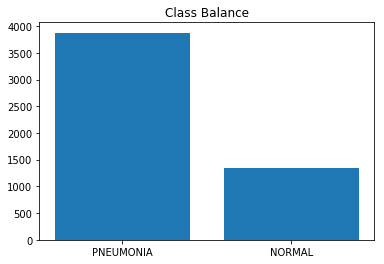

In [10]:
plot_balance(train_dir, train_cat)

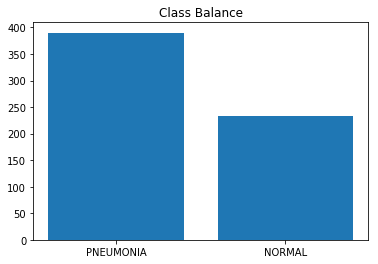

In [11]:
plot_balance(test_dir, test_cat)

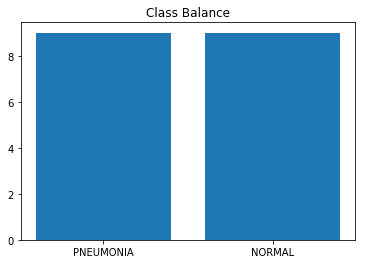

In [12]:
plot_balance(val_dir, val_cat)

## Balancing Methods

- Undersample: Take samples of majority class
- Oversample: Make copies of minority class
- Weight Balancing: We can adjust weights for each class
- SMOTE

## Image Preprocessing

Text(0.5, 1.0, 'Pneumonia')

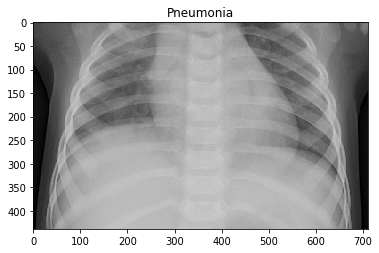

In [13]:
plt.imshow(mpimg.imread(path_to_train + '/PNEUMONIA/person1_bacteria_1.jpeg'))
plt.title('Pneumonia')

Text(0.5, 1.0, 'Normal')

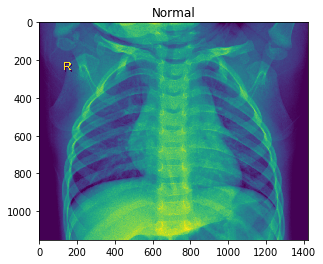

In [14]:
plt.imshow(mpimg.imread(path_to_train + '/NORMAL/IM-0117-0001.jpeg'))
plt.title('Normal')

## CNN Architecture

- Some of the layers within CNN's:  Convolutional Layer, Pooling Layer, Activation Layer, and Fully-Connected Layer
<br><br>   
- **Convolutional Layer** - Image becomes stack of filtered images (depending on how many filters you choose to use)
   Parameters:
   - Number of filters
   - Size of filters

<img src="img/picture.png" width="400">


- **Pooling Layer** - Downsample the stack of filtered images<BR>
    Parameters:
    - Window size
    - Window stride

<img src="img/picture2.png" width="500">

- **Nonlinearity function**
    - ReLu Activation Layer - Steps through values in images and converts negative numbers to zero 
    - Softmax - Outputs probability pertaining to each class
    - Sigmoid

<img src="img/relu.png" width="400">

- **Fully Connected Layer** - Where each neuron will be connected to all neurons in next layer

<img src="img/fully.png" width="350">

## Data Augmentation

In [14]:
ImageDataGenerator?

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255)

valid_datagen = ImageDataGenerator(
        rescale=1./255) 


In [16]:
batch_size = 32
image_size = 128
    
train_generator = train_datagen.flow_from_directory(
        path_to_train,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        path_to_test,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary')


validation_generator = valid_datagen.flow_from_directory(
        path_to_val,
        target_size=(image_size,image_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary')

print("Shape of training images {}".format(train_generator.image_shape))
print("Shape of test images {}".format(test_generator.image_shape))
print("Shape of validation images {}".format(validation_generator.image_shape))
#classes=['Normal','Pneumonia'],

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Shape of training images (128, 128, 1)
Shape of test images (128, 128, 1)
Shape of validation images (128, 128, 1)


In [17]:
train_generator.class_mode

'binary'

In [18]:
train_generator.samples

5216

In [19]:
test_generator.samples

624

In [20]:
validation_generator.samples

16

In [21]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Create model

In [20]:
def create_model():
    global model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(image_size, image_size, 1))) 
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))


In [21]:
create_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
__________

##  Callbacks

In [20]:
EarlyStopping?

In [17]:
ReduceLROnPlateau?

In [18]:
optimizer = 'adam'
epoch = 15
loss = 'binary_crossentropy'

NAME = 'X_ray_classifier-{}-{}-{}'.format(optimizer,epoch,loss)

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

es = EarlyStopping(patience=5)

#checkpoint = ModelCheckpoint('best_model.h5',save_best_only=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1) 

## Optimizer

- Stochastic Gradient Descent: parameter update for each training example <br>
    - Momentum tries to help optimizer move in direction of global minima
- Adam: Computes adaptive learning rates for each parameter<br>
- RMSprop: Adaptive learning rate<br>

## Loss

- Using Crossentropy loss as our loss function we will calculate the log probability of an image having pneumonia
- MSE: Average of the squares of the errors

In [19]:
model.compile(optimizer = optimizer, loss = loss, metrics=['accuracy'])

NameError: name 'model' is not defined

## Train Model

In [28]:
history = model.fit_generator(
          train_generator,
          epochs=epoch,
          steps_per_epoch=train_generator.samples // batch_size,
          validation_data=test_generator,
          validation_steps=test_generator.samples // batch_size,
          callbacks=[es, tensorboard, lr_reduce])

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
163/163 [==============================] - 67s 410ms/step - loss: 0.3823 - acc: 0.8299 - val_loss: 0.4466 - val_acc: 0.8173
Epoch 2/15
163/163 [==============================] - 64s 390ms/step - loss: 0.2598 - acc: 0.8959 - val_loss: 0.5341 - val_acc: 0.7901
Epoch 3/15
163/163 [==============================] - 65s 399ms/step - loss: 0.2270 - acc: 0.9086 - val_loss: 0.4450 - val_acc: 0.8269
Epoch 4/15
163/163 [==============================] - 64s 390ms/step - loss: 0.2059 - acc: 0.9202 - val_loss: 0.5704 - val_acc: 0.8381
Epoch 5/15
163/163 [==============================] - 65s 400ms/step - loss: 0.1845 - acc: 0.9275 - val_loss: 0.3860 - val_acc: 0.8846
Epoch 6/15
163/163 [==============================] - 64s 391ms/step - loss: 0.1679 - acc: 0.9367 - val_loss: 0.3917 - val_acc: 0.8413
Epoch 7/15
163/163 [==============================] - 63s 387ms/step - loss: 0.1573 - acc: 0.9410 - val_loss: 0.3780 - val_acc: 0.8862
Epoch 8

## Evaluate

In [29]:
#Confusion Matrix
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[8 0]
 [8 0]]


**Precision = TP / (TP + FP)<br>
Recall (Sensitivity) = TP / (TP + FN)<br>
Specificity = TN / (TN + FP)<br>
F1 = 2 × (Precision * Recall / Precision + Recall)<br>
Accuracy = Total Correct Prediction / Total Prediction Made * 100<br><br>**
- We could also calculate confidence intervals like the one done in CheXNet<br>
     - Confidence interval = z * sqrt( (error * (1 - error)) / n)

In [30]:
print('Classification Report')
target_names = ['Normal','Pneumonia']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67         8
   Pneumonia       0.00      0.00      0.00         8

   micro avg       0.50      0.50      0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we can see the model needs work, this is at baseline accurary

In [31]:
model.evaluate_generator(validation_generator,steps=16)

[0.6905431151390076, 0.6875]

In [32]:
def create_plots(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy-{}'.format(NAME))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss-{}'.format(NAME))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

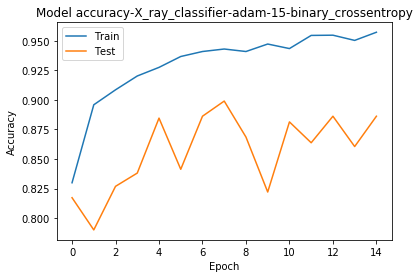

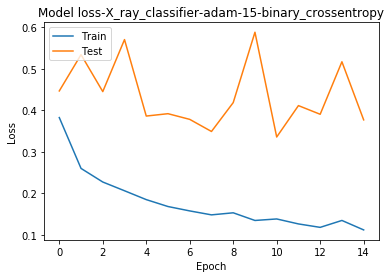

In [33]:
create_plots(history)

## Save model

In [68]:
model.save('cnn.h5')

## Class Activation Maps
- We can use class activation maps to visualize images and highlight areas that were most important for classification

## Visualize Conv Filters

- This visualization process gives us a better understanding of how these convolutional neural networks learn.

## - Optimization techniques

<font size='4'>
 - Manual Tuning <br>
 - GridSearch <br>
 - RandomSearch <br>
 - Bayesian Optimization <br>
</font>

## Tensorboard 
- Visualize model performance and graph network

## - Deploying to Production via Flask/RESTful API

In [3]:
MODEL_PATH = 'cnn.h5'

# Load your trained model
model = load_model(MODEL_PATH)
model._make_predict_function()
print('Model loaded. Check http://127.0.0.1:5000/')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Model loaded. Check http://127.0.0.1:5000/


In [16]:
img = 'img/normal.jpg'

In [17]:
def prepare_image(image, target):
    # if the image mode is not RGB, convert it
    image = Image.open(img)
    
    if image.mode == "RGB":
        image = image.convert("L")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    image = image.reshape(-1,128,128,1) / 255.
    
    # return the processed image
    return image

In [20]:
#prepare_image(img,target=(128, 128))

In [21]:
def model_predict(img_path, model):
    data = {'success': False}
    image = Image.open(img)
    image = prepare_image(image, target=(128,128))
    prediction = model.predict(image)
    class_predicted = np.argmax(prediction)
    data['prediction'] = []
    data['prediction'].append(class_predicted)
    data['success'] = True
    return str(data)

In [24]:
validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [83]:
model_predict(img, model)

"{'success': True, 'prediction': [0]}"